### Sentiment Analysis IMDB Reviews


In [1]:
import string
import re
import codecs
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import feature_extraction
from sklearn import linear_model
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
import itertools
import nltk
import ssl
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from datetime import datetime
from collections import Counter

In [2]:
data = pd.read_csv('IMDBDataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
values = data['sentiment'].value_counts()

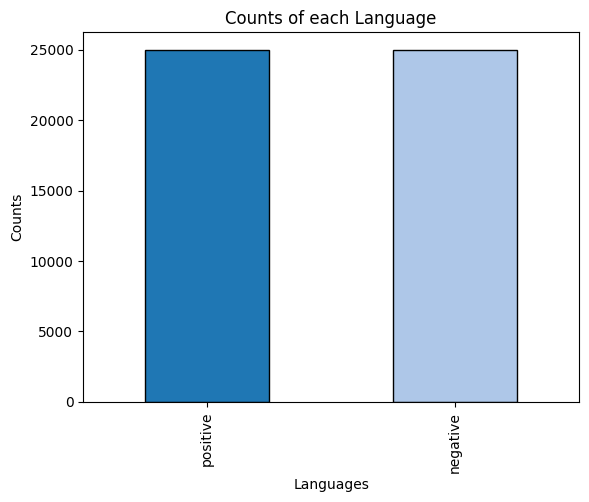

In [4]:
# Create a list of colors for each bar
colors = plt.cm.tab20.colors[:len(values)]

values.plot(kind='bar', color=colors, edgecolor='black')
plt.xlabel('Languages')
plt.ylabel('Counts')
plt.title('Counts of each Language')

plt.show()

In [5]:
# Select words to count
words_to_count = ['great', 'bad', 'love', 'disappointed', 'good']

# Function to count words
def count_words(review, words_to_count):
    review_words = review.lower().split()
    word_counter = Counter(review_words)
    return {word: word_counter[word] for word in words_to_count}

# Apply the function to the dataframe
word_counts = data['review'].apply(lambda x: count_words(x, words_to_count))
word_counts_df = pd.DataFrame(word_counts.tolist()).fillna(0)

# Combine with original dataframe
df = pd.concat([data, word_counts_df], axis=1)

# Count word occurrences by sentiment
word_sentiment_count = df.groupby('sentiment')[words_to_count].sum().reset_index()
print(word_sentiment_count)

  sentiment  great    bad  love  disappointed   good
0  negative   4326  10613  3592           637  11653
1  positive  11139   2881  7156           352  11814


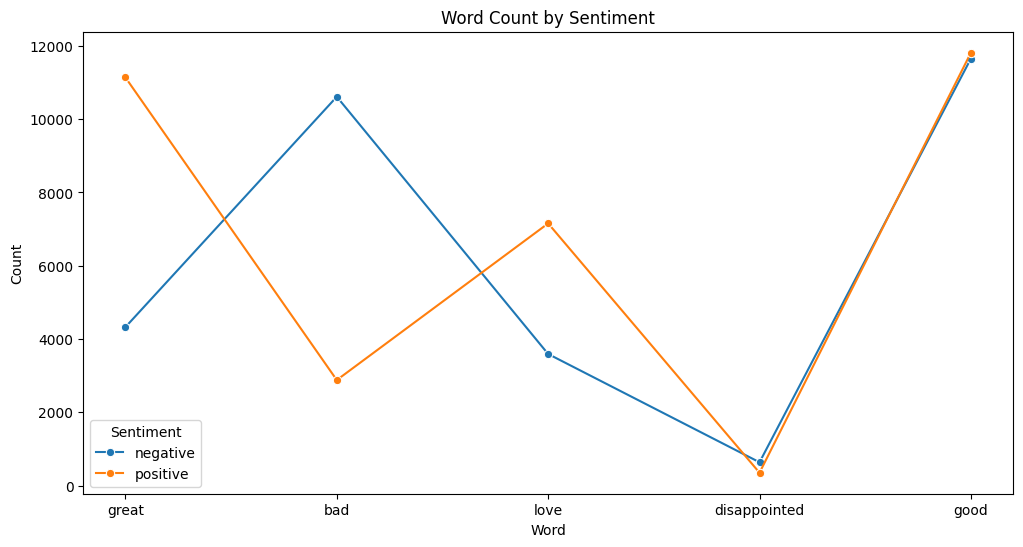

In [6]:
# Melting the dataframe for easier plotting
word_sentiment_count_melted = word_sentiment_count.melt(id_vars='sentiment', var_name='word', value_name='count')

# Line plot of word counts by sentiment
plt.figure(figsize=(12, 6))
sns.lineplot(data=word_sentiment_count_melted, x='word', y='count', hue='sentiment', marker='o')
plt.title('Word Count by Sentiment')
plt.xlabel('Word')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.show()

In [7]:
data['sentiment'] = data['sentiment'].map({'positive': 1, 'negative': 0})

In [8]:

def preprocessText(text, removeStopWords = True):

    text = text.lower()

    #removes HTML tags
    text = re.sub(r'<[^<>]+>', ' ', text)

    #removing all special characters and numbers
    text = re.sub(r'[!@#$(),n"%^*?:;~`0-9]', ' ', text)
    text = re.sub(r'[[]]', ' ', text)
    
    return text

In [9]:
data["review"] = data["review"].apply(preprocessText)

/var/folders/9x/tctkyrd16cz4wlf7lrl6qth00000gn/T/ipykernel_35227/1200323450.py:10: FutureWarning: Possible nested set at position 1
  text = re.sub(r'[[]]', ' ', text)


In [10]:

class SentimentAnalysisEngine:
    def __init__(self, X_train, y_train, X_test, y_test, model, vectorizer):
        self.model = model
        self.vectorizer = vectorizer
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.y_pred = None
        self.y_pred_test = None
        self.PipeLine = None


    def createPipeline(self):
        self.PipeLine = pipeline.Pipeline([
            ('vectorizer', self.vectorizer),
            ('clf', self.model)
        ])

    def fit(self, test_size = 0.2):
        self.createPipeline()
        self.PipeLine.fit(self.X_train, self.y_train)

    def predict(self):
        self.fit()
        y_pred = self.PipeLine.predict(self.X_train)
        y_pred_test = self.PipeLine.predict(self.X_test)
        return y_pred, y_pred_test

    def report(self):
        self.y_pred, self.y_pred_test = self.predict()
        print("Train Accuracy:", metrics.accuracy_score(self.y_train, self.y_pred))
        print("Test Accuracy:", metrics.accuracy_score(self.y_test, self.y_pred_test))
        # Additional evaluation metrics
        print("Train Precision:", metrics.precision_score(self.y_train, self.y_pred, average='weighted'))
        print("Test Precision:", metrics.precision_score(self.y_test, self.y_pred_test, average='weighted'))
        print("Train Recall:", metrics.recall_score(self.y_train, self.y_pred, average='weighted'))
        print("Test Recall:", metrics.recall_score(self.y_test, self.y_pred_test, average='weighted'))
        print("Train F1-score:", metrics.f1_score(self.y_train, self.y_pred, average='weighted'))
        print("Test F1-score:", metrics.f1_score(self.y_test, self.y_pred_test, average='weighted'))
        
    def plotConfusionMatrix(self):

        conf_matrix = confusion_matrix(self.y_test, self.y_pred_test)

        # Plot confusion matrix as a heatmap
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()

    def getPipeLine(self):
        return self.PipeLine

    def cross_validate(self, cv=5):
        scores = cross_val_score(self.PipeLine, self.X_train, self.y_train, cv=cv)
        print("Cross-validation scores:", scores)
        print("Mean CV accuracy:", scores.mean())

   



In [11]:
X_train, X_test, y_train, y_test = train_test_split( data['review'], data['sentiment'], test_size=0.2, random_state=42)

In [12]:
vectorizer = feature_extraction.text.TfidfVectorizer(ngram_range=(1,3), analyzer='char')
# x = vectorizer.fit_transform(df['Text'])


In [13]:
DetectorClassNB = SentimentAnalysisEngine(X_train,y_train,X_test,y_test,MultinomialNB(),vectorizer)

In [14]:
DetectorClassNB.report()

Train Accuracy: 0.815
Test Accuracy: 0.8019
Train Precision: 0.8152748168675734
Test Precision: 0.8024199580679817
Train Recall: 0.815
Test Recall: 0.8019
Train F1-score: 0.8149526540670254
Test F1-score: 0.8018547972972021


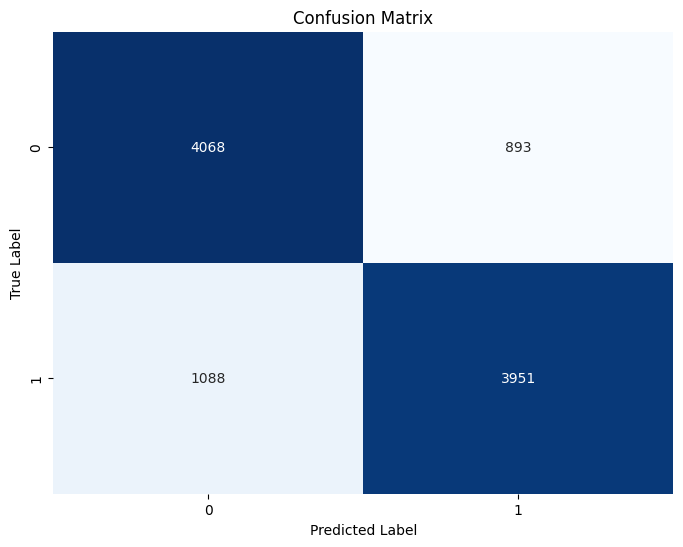

In [15]:
DetectorClassNB.plotConfusionMatrix()

In [16]:
DetectorClassLR = SentimentAnalysisEngine(X_train,y_train,X_test,y_test,LogisticRegression(),vectorizer)

In [17]:
DetectorClassLR.report()

Train Accuracy: 0.8391
Test Accuracy: 0.8319
Train Precision: 0.8391315896304299
Test Precision: 0.8319058049797204
Train Recall: 0.8391
Test Recall: 0.8319
Train F1-score: 0.8390980386152264
Test F1-score: 0.8318938417382405


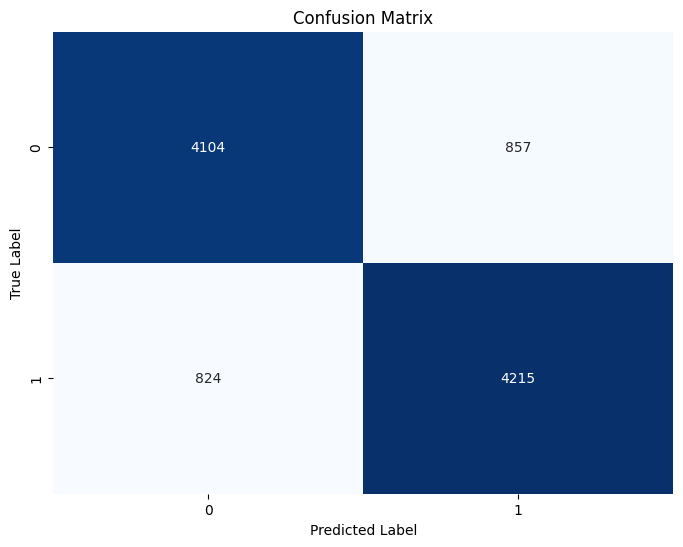

In [18]:
DetectorClassLR.plotConfusionMatrix()

In [19]:
custom_token_pattern = r'\b\w+\b'
#min_df = .0005  means that a term must appear in at least 0.05% of the documents to be considered.
stopWords = [
    "a", "an", "and", "are", "as", "at", "be", "but", "by", "for",
    "if", "in", "into", "is", "it", "no", "not", "of", "on", "or",
    "such", "that", "this","the", "their", "then", "there", "these", "they",
    "this", "to", "was", "will", "with"
]
CVectorizer = CountVectorizer(lowercase = False,min_df=.0005, stop_words = stopWords, token_pattern = custom_token_pattern)

In [20]:
DetectorClassDT = SentimentAnalysisEngine(X_train,y_train,X_test,y_test,DecisionTreeClassifier(max_depth=400),CVectorizer)

In [21]:
DetectorClassDT.report()

Train Accuracy: 1.0
Test Accuracy: 0.7249
Train Precision: 1.0
Test Precision: 0.7250442674171547
Train Recall: 1.0
Test Recall: 0.7249
Train F1-score: 1.0
Test F1-score: 0.7248922008581443


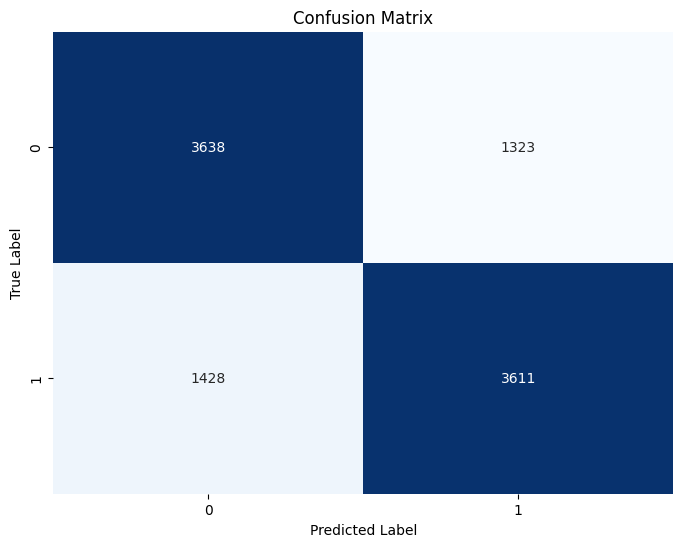

In [22]:
DetectorClassDT.plotConfusionMatrix()

In [23]:
DetectorClassLRCV = SentimentAnalysisEngine(X_train,y_train,X_test,y_test,LogisticRegression(max_iter = 1000),CVectorizer)

In [24]:
DetectorClassLRCV.report()

Train Accuracy: 0.983075
Test Accuracy: 0.8785
Train Precision: 0.9830782253559112
Test Precision: 0.8786720636543468
Train Recall: 0.983075
Test Recall: 0.8785
Train F1-score: 0.9830750145660848
Test F1-score: 0.8784737670849703


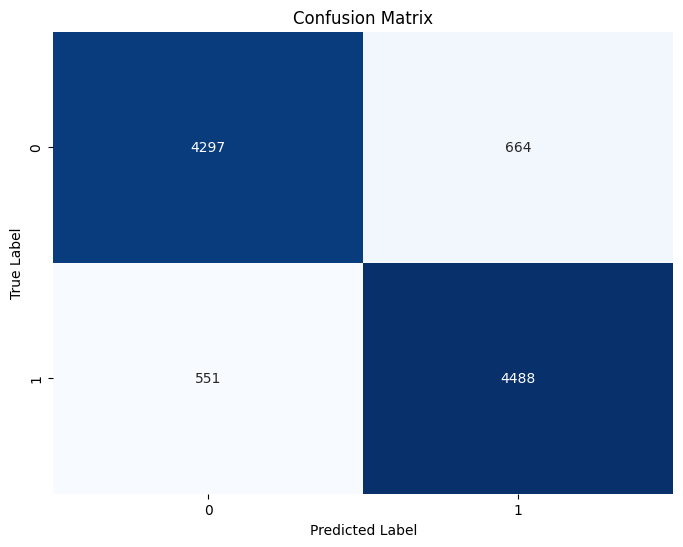

In [25]:
DetectorClassLRCV.plotConfusionMatrix()

In [26]:
DetectorClassLR.cross_validate()

Cross-validation scores: [0.82975  0.826375 0.833    0.816375 0.82775 ]
Mean CV accuracy: 0.8266499999999999


In [27]:
DetectorClassNB.cross_validate()

Cross-validation scores: [0.805625 0.801    0.81175  0.793125 0.802875]
Mean CV accuracy: 0.802875


In [28]:
DetectorClassLRCV.cross_validate()

Cross-validation scores: [0.8735   0.87625  0.873375 0.872    0.866375]
Mean CV accuracy: 0.8722999999999999


In [29]:
PipeLine = DetectorClassLRCV.getPipeLine()

In [30]:
import pickle

In [31]:
with open("lrmodel.pkl", "wb") as f:
    pickle.dump(PipeLine, f)

